Markowitz Portfolio Optimization
=================
Final Project for CPSC 458 by Connor Durkin
-----------------------------
This project explores the use of a mean variance or Markowitz method of portfolio optimization. The goal is to employ this trading strategy for a portfolio of SPDR ETFs and track returns over historical data. More importantly, though, as this is a class in decision making, I have incporated the ability for the functions here to explain their motivations to a human being--hopefully in a palatable manner. Below are the function definitions and at the end of the notebook you will find an example of their use. These functions were written with default key values but the operations are general enough to apply this strategy to any selection of securities with return data available via yahoo finance. 


In [206]:
%matplotlib inline
import yahoo_finance
from yahoo_finance import Share
import numpy as np
import pandas
import pprint
import matplotlib.pyplot as plt
import datetime
import cvxopt as opt
from cvxopt import blas, solvers
# We will do a lot of optimizations, 
# and don't want to see each step.
solvers.options['show_progress'] = False

getTimeSeries( ticker, start_date, end_date) 
--------------
#### What it does:
getTimeSeries() takes in a date range and a ticker and returns a timeseries of adjusted closing prices.
#### Inputs:
* *ticker*: a string indiciating the security for which the time series will be generated.
* *start_date*: a string of the form 'YYYY-MM-DD' declaring the beginning of the historical window.
* *end_date*: a string of the form 'YYYY-MM-DD' declaring the end of the historical window

#### Returns:
* *time_series*: a single column Pandas DataFrame containing the time series of adjusted close prices
    for the indicated ticker.


In [4]:
def getTimeSeries( ticker, start_date='2012-01-01', end_date='2012-02-01'):
    # yahoo_finance API to load list of dictionaries 
    obj = Share(ticker)
    ts = obj.get_historical(start_date,end_date)
    # yahoo_finance indexes most recent date first, reverse this
    ts = list(reversed(ts))
    # Convert date strings to python datetime objects for easier manipulation
    dates = [datetime.datetime.strptime(ts[i]['Date'],'%Y-%m-%d').date() for i in range(len(ts))]
    # Convert close price strings to floats for numerical manipulation
    prices = [float(ts[i]['Adj_Close']) for i in range(len(ts))]
    # Create DataFrame from the list produced - python will recognize as Series
    time_series = pandas.DataFrame( prices, index = dates, columns = [ticker])
    return time_series

getMultTimeSeries( tickers, start_date, end_date) 
--------------
#### What it does:
getMultTimeSeries() takes in a list of tickers and a specified date range and returns a Pandas DataFrame containing timeseries of adjusted closing prices. 
#### Inputs:
* *tickers*: a list of strings indicating which tickers to include. Defaults to these 9 SPDR ETFs: 'XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLK','XLU'.
* *start_date*: a string of the form 'YYYY-MM-DD' declaring the beginning of the historical window.
* *end_date*: a string of the form 'YYYY-MM-DD' declaring the end of the historical window

#### Returns:
* *time_series_dataframe*: a dataframe of adjusted closing price timeseries over the specified date range for the specified group of tickers

In [5]:
def getMultTimeSeries( tickers = ['XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLK','XLU'],
                     start_date = '2012-01-01', end_date = '2012-02-01'):
    # Initialize DataFrame
    time_series_dataframe = pandas.DataFrame()
    # Iterate over all tickers and append column to DataFrame
    for ticker in tickers:
        # Use helper function to get single column DataFrame
        df = getTimeSeries( ticker, start_date, end_date)
        # Concatanate on axis = 1
        time_series_dataframe = pandas.concat([time_series_dataframe,df],axis = 1)
    return time_series_dataframe    

markowitzReturns( returns)
-------------------------
#### What it does:
markowitzReturns() takes in a Pandas DataFrame (or any container which can be converted to a numpy matrix) of returns and uses mean-variance portfolio theory to return an optimally weighted portfolio. It does so by minimizing $\omega^{T}\Sigma\omega -qR^{T}\omega$ (the Markowitz mean - variance framework) for portfolio weights $\omega$. Where $\Sigma$ is the covariance matrix of the securities, $R$ is the expected return matrix and $q$ is the mean return vector of all securities. The optimization is performed using the CVXOPT package employing the use of the solvers.qp() quadratic programming method. This method minimizes $(1/2)x^{T}Px + q^{T}x$ subject to $Gx \preceq h$ and $Ax = b$. It also utilizes CVXOPT's BLAS methods for performing linear algebra computations. Inspiration for this process was found in Dr. Thomas Starke, David Edwards and Dr. Thomas Wiecki's quantopian blog post located at: http://blog.quantopian.com/markowitz-portfolio-optimization-2/.

#### Inputs:
* *returns*: a Pandas DataFrame(or other container which can be converted to a numpy matrix). NOTE: the dataframe produced by getMultTimeSeries must be transposed (returns.T) for meaningful results. 
* *justify*: a True / False input determining whether to print a robust explanation of the choice for the portfolio shift. 

#### Returns:
* *optimal_weights*: the weights of the optimal portfolio in array form.
* *returns*: the returns of all portfolios calculated across the effecient frontier.
* *risks*: list of risks of all portfolios calculated across the efficient frontier.

In [248]:
def markowitzReturns( returns, tickers, explain = False):
    n = len(returns)
    returns_df = returns
    returns = np.asmatrix(returns)
    mus = [10**(5.0 * t/50 - 1.0) for t in range(50)]
    # Convert to cvxopt matrices
    Sigma = opt.matrix(np.cov(returns))
    q = opt.matrix(np.mean(returns, axis=1))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))  # -I*w < 0 i.e. no shorts
    A = opt.matrix(1.0, (1, n))  # A is all ones so A*w = w
    b = opt.matrix(1.0)          # Dot product sums to 1 
    # Calculate efficient frontier weights using quadratic programming
    ports = [solvers.qp(mu*Sigma, -q, G, h, A, b)['x'] for mu in mus]
    # Calculate risks and returns of frontier 
    returns = [blas.dot(q, x) for x in ports]
    risks = [np.sqrt(blas.dot(x, Sigma*x)) for x in ports]
    # Fit polynomial to frontier curve 
    m = np.polyfit(returns, risks, 2)
    x = np.sqrt(m[2]/m[0])
    # Calculate optimal portfolio weights
    optimal_weights = solvers.qp(opt.matrix(x * Sigma), -q, G, h, A, b)['x']
    optimal_return = blas.dot(q, optimal_weights)
    optimal_risk = np.sqrt(blas.dot(optimal_weights, Sigma*optimal_weights))
    # Method to justify this portfolio distribution if asked for 
    if( explain ):
        date_text = """
--------------------------------------------------------------------------------------------------

Using returns data from {0} to {1} a careful mean - variance analysis was performed. 
The analysis found a number of portfolios lying on the markowitz efficient frontier and they are 
found below. The analysis indicates that the optimal portfolio for the next trading day will have 
the following distribution:
"""
        print(date_text.format(returns_df.columns[0],returns_df.columns[len(returns_df.columns)-1]))
        # Print optimal weights 
        weights = np.asarray(optimal_weights)
        weights = [float(weights[i]) for i in range(len(weights))]
        wts = dict(zip(tickers,weights))
        pp = pprint.PrettyPrinter(indent=4)
        for k in wts:
            weight_text = "\t{0} : {1:.4f}%"
            print(weight_text.format(str(k),float(wts[k])*100))
        returns_text = """
This portfolio distribution has an expected return of:
        {0:.4f}%"""
        print(returns_text.format(float(optimal_return)*100))
        risk_text = """
And the associated risk (standard deviation) is:
        {0:.4f}"""
        print(risk_text.format(float(optimal_risk)))
        break_text="""
--------------------------------------------------------------------------------------------------
        """
        print(break_text)
        plt.plot(risks, returns, 'b-o')
        plt.title('Efficient Portfolios on {}'.format(returns_df.columns[len(returns_df.columns)-1]))
        plt.ylabel('Returns (%)')
        plt.xlabel('Risk (STD)')
    return np.asarray(optimal_weights), returns, risks 

backtest( tickers, start_date, end_date, start, max_lookback, explain)
----------
#### What it does:
backtest() applies the mean-variance portfolio optimization trading strategy to a list of stocks. It applies the markowitzReturns() method over a range of dates and tracks the portfolio movement and returns, outputting a DataFrame describing the portfolio over time, a DataFrame describing the returns over time and a total return amount. **Backtest does not take into account commission costs.** Running backtest(explain = True) produces the output below. The default dates were carefully selected so that just one explain instance would print. 

#### Inputs:
* *tickers*: a list of strings indicating which tickers to include. Defaults to these 9 SPDR ETFs: 'XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLK','XLU'.
* *start_date*: a string of the form 'YYYY-MM-DD' declaring the beginning of the historical window.
* *end_date*: a string of the form 'YYYY-MM-DD' declaring the end of the historical window
* *start*: the minimum number of days to wait before beginning to trade (i.e. how much information is needed). Default is 10.
* *max_lookback*: the maximum number of days to look back for data, i.e. the size of the input to markowitzReturns(). Default is 100.

#### Returns:
* *weights_df*: a pandas DataFrame containing the portfolio weights over time beginning with the start date + start$*$days.
* *total_returns*: a pandas DataFrame containing the portfolio returns over time beginning with the start date + start$*$days.
* *naive_return*: the total naive return (numpy float).


--------------------------------------------------------------------------------------------------

Using returns data from 2012-01-04 to 2012-01-19 a careful mean - variance analysis was performed. 
The analysis found a number of portfolios lying on the markowitz efficient frontier and they are 
found below. The analysis indicates that the optimal portfolio for the next trading day will have 
the following distribution:

	XLU : 0.0000%
	XLF : 0.0000%
	XLY : 0.0000%
	XLI : 0.0000%
	XLB : 99.9999%
	XLE : 0.0000%
	XLV : 0.0000%
	XLP : 0.0000%
	XLK : 0.0000%

This portfolio distribution has an expected return of:
        0.5945%

And the associated risk (standard deviation) is:
        0.0073

--------------------------------------------------------------------------------------------------
        


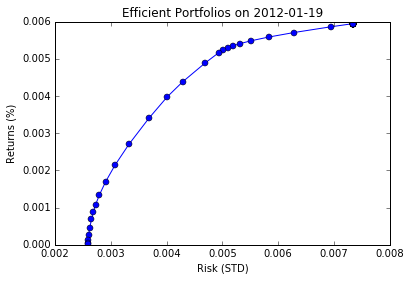

In [251]:
def backtest( tickers = ['XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLK','XLU'],
             start_date = '2012-01-01', end_date = '2012-01-20', start = 10, max_lookback = 100,
             explain = False):
    timeseries = getMultTimeSeries( tickers, start_date, end_date)
    returns = timeseries.pct_change().dropna()
    weights_df = pandas.DataFrame()
    for i in range(len(returns)):
        if ( i > start ):
            if( i < max_lookback ):
                returns_window = returns[0:i]
            else:
                returns_window = returns[(i-max_lookback):i]
            try:
                if( explain ):
                    weights, returns_window, risks = markowitzReturns(returns_window.T, tickers, explain = True)
                else:
                    weights, returns_window, risks = markowitzReturns(returns_window.T, tickers, explain = False)
            except ValueError as e:
                # Sometimes CVXOPT fails (infrequently)
                # "ValueError: Rank(A) < p or Rank([P; A; G]) < n"
                # In this case just do nothing (keep current weights)
                weights, returns_window, risks = weights_prev, returns_window_prev, risks_prev
            weights = [float(weights[i]) for i in range(len(weights))]
            wts = dict(zip(tickers,weights))
            df = pandas.DataFrame(wts, index = [returns.index[i]])
            weights_df = pandas.concat([weights_df, df])
            weights_prev, returns_window_prev, risks_prev = weights, returns_window, risks
    total_returns = pandas.DataFrame(weights_df.values*returns[(start+1)::],
                                     columns = returns.columns, index = returns.index)
    naive_returns = [np.sum(total_returns[[i]]) for i in range(len(total_returns.columns))]
    naive_return = np.sum(naive_returns)
    return weights_df, total_returns.dropna(), naive_return
weights, returns, naive_return = backtest(explain = True)

analyzeResults( weights_df, total_returns, naive_return, commission)
---------------
#### What it does:
analyzeResults() is the final function which analyzes and displays the results of the backtest() function. It takes the output of backtest() plus an argument for the commission wich defaults to 4 basis points. It plots the real and naive returns over time and displays the total real and naive returns over the date range from backtest(). *below is an example from 2012-2013. 
#### Inputs:
* *weights_df*: pandas DataFrame of portfolio weights over time, returned from backtest().
* *total_returns*: pandas DataFrame of naive returns over time, returned from backtest().
* *naive_return*: total naive_return as returned by backtest().
* *commission*: basis point cost on trades, defualts to 4 basis points. 

#### Returns:
* nothing


--------------------------------------------------------------------------------------------------
In trading from 2012-01-20 to 2012-12-31 the total return ignoring commission fees was:
        
        10.4554%
        
After factoring in commission fees of 0.0004 the total return was:
        
        8.6154%
        
 --------------------------------------------------------------------------------------------------       
    


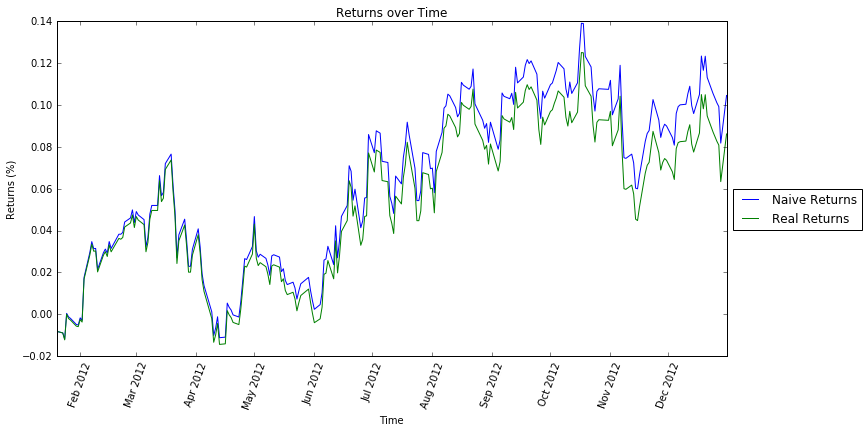

In [338]:
weights, returns, naive_return = backtest(start_date='2012-01-01',end_date='2012-12-31')
def analyzeResults( weights_df, total_returns, naive_return, commission = .0004):
    start_date = weights_df.index[0]
    end_date = weights_df.index[len(weights_df.index)-1]
    # Get cummulative sum of returns for plotting
    return_sums = total_returns.cumsum()
    return_sums['total_return'] = return_sums.sum(axis=1)
    # Analyze data with commission costs 
    weights_diff = weights_df.diff()
    weights_diff['total_delta'] = weights_diff.abs().sum(axis = 1)
    portfolio_movement = pandas.DataFrame(weights_diff['total_delta']/2)
    portfolio_movement['commissions'] = portfolio_movement['total_delta']*commission
    portfolio_movement['naive_return'] = total_returns.sum(axis=1)
    portfolio_movement['real_return'] = (portfolio_movement['naive_return'] - portfolio_movement['commissions'])
    real_sums = portfolio_movement.cumsum()
    real_return = portfolio_movement['real_return'].sum()
    # Print naive_return and real_return + analysis
    naive_return_text = """
--------------------------------------------------------------------------------------------------
In trading from {0} to {1} the total return ignoring commission fees was:
        
        {2:.4f}%
        
After factoring in commission fees of {3} the total return was:
        
        {4:.4f}%
        
 --------------------------------------------------------------------------------------------------       
    """
    print(naive_return_text.format( start_date, end_date, naive_return*100, commission ,real_return*100) )
    # Get plot of naive_returns and real returns over time 
    plt.figure(figsize=(12,6))
    plt.plot(return_sums.index,return_sums['total_return'],label='Naive Returns')
    plt.plot(real_sums.index,real_sums['real_return'],label='Real Returns')
    plt.title('Returns over Time')
    plt.xlabel('Time')
    plt.ylabel('Returns (%)')
    plt.xticks(rotation=70)
    plt.legend()
    plt.legend(bbox_to_anchor=(1.01, .5), loc=2, borderaxespad=0.)
    return
analyzeResults( weights, returns, naive_return, commission = .0004)